In [1]:
import numpy as np
import cv2
import os
from random import shuffle
from tqdm import tqdm

TRAIN_DIR = 'train'
TEST_DIR = 'test'
IMG_SIZE = 50
LR = 1e-3 #Learning Rate (0.001)

MODEL_NAME = "dogsvscats - {}-{}.model".format(LR, "2-conv-basic")

In [2]:
# One Hot encoding to structure the data for the convnet
def label_image(img):
    word_label = img.split(".")[0]
    if word_label == 'cat': return [1,0]
    elif word_label == 'dog': return [0,1]

In [3]:
def create_train_data():
    train_data = []
    for img in tqdm(os.listdir(TRAIN_DIR)):
        label = label_image(img)
        # Get the image path
        path = os.path.join(TRAIN_DIR, img)
        img = cv2.resize(cv2.imread(path, cv2.IMREAD_GRAYSCALE), (IMG_SIZE, IMG_SIZE))
        train_data.append([np.array(img), np.array(label)])
    shuffle(train_data)
    np.save('training.npy', train_data)
    return train_data

In [4]:
def process_testing_data():
    testing_data = []
    for img in tqdm(os.listdir(TEST_DIR)):
        # Get the image path
        path = os.path.join(TEST_DIR, img)
        img_num = img.split('.')[0]
        img = cv2.resize(cv2.imread(path, cv2.IMREAD_GRAYSCALE), (IMG_SIZE, IMG_SIZE))
        testing_data.append([np.array(img), img_num])
    np.save('testing.npy', testing_data)
    return testing_data

In [5]:
# Create the training data
train_data = create_train_data()

100%|██████████| 25000/25000 [01:18<00:00, 318.02it/s]


In [6]:
import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression

import tensorflow as tf
tf.reset_default_graph()

# Creating the input layer
convnet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 1], name='input')

# Creating the first layer with maxpooling and relu activation function

# This originally consisted of only 2 conv layers which returned an accuracy of only 50% so we added more conv layers
# to achieve better results
convnet = conv_2d(convnet, 32, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 64, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 32, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 64, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 32, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 64, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 32, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 64, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

# Creating the fully connected layers
convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.8)

convnet = fully_connected(convnet, 2, activation='softmax')
convnet = regression(convnet, optimizer='adam', learning_rate=LR, loss='categorical_crossentropy', name='targets')

model = tflearn.DNN(convnet, tensorboard_dir ='log')


In [7]:
# Check for checkpoints
if os.path.exists('{}.meta'.format(MODEL_NAME)):
    model.load(MODEL_NAME)
    print('Model Loaded')

In [8]:
# Division of dataset into training and validation sets
train = train_data[:-500]
validation = train_data[-500:]

In [11]:
X = np.array([i[0] for i in train]).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
y = [i[1] for i in train]

X_t = np.array([i[0] for i in validation]).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
y_t = [i[1] for i in validation]

In [10]:
model.fit({'input': X}, {'targets': y}, n_epoch=5, validation_set=({'input': X_t}, {'targets': y_t}), 
    snapshot_step=500, show_metric=True, run_id=MODEL_NAME)

Training Step: 1914  | total loss: 0.49731 | time: 113.557s
| Adam | epoch: 005 | loss: 0.49731 - acc: 0.7562 -- iter: 24448/24500
Training Step: 1915  | total loss: 0.50093 | time: 114.853s
| Adam | epoch: 005 | loss: 0.50093 - acc: 0.7556 | val_loss: 0.60536 - val_acc: 0.6940 -- iter: 24500/24500
--


100%|██████████| 12500/12500 [00:39<00:00, 314.91it/s]
/Users/navneetmkumar/anaconda/lib/python3.5/site-packages/matplotlib/font_manager.py:280: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


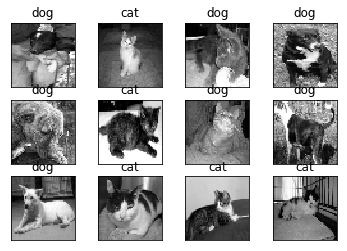

In [13]:
# Plotting the results of the classifier
%matplotlib inline
import matplotlib.pyplot as plt

test_data =  process_testing_data()

fig = plt.figure()

# Display the label and data
for num, data in enumerate(test_data[:12]):
    # cat : [1,0]
    # dog : [0,1]
    
    img_data = data[0]
    img_num = data[1]
    
    y = fig.add_subplot(3,4,num+1)
    orig = img_data
    data = img_data.reshape(IMG_SIZE, IMG_SIZE, 1)
    model_out = model.predict([data])[0]
    if np.argmax(model_out) == 1: 
        str_label = 'dog'
    else:
        str_label = 'cat'
        
    y.imshow(orig, cmap='gray')
    plt.title(str_label)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
plt.show()

In [14]:
# Creating the kaggle submission file
with open('submission-file.csv', 'w') as f:
    f.write('id,label\n')

In [15]:
with open('submission-file.csv', 'a') as f:
    for data in tqdm(test_data):
        img_data = data[0]
        img_num = data[1]
        orig = img_data
        data = img_data.reshape(IMG_SIZE, IMG_SIZE, 1)
        model_out = model.predict([data])[0]
        f.write('{},{}\n'.format(img_num, model_out[1]))

100%|██████████| 12500/12500 [00:33<00:00, 369.56it/s]
